## Aims

We process RTS sample scenarios to understand input-output relationship between RTS scenarios and Vatic outputs:
(i) total daily system costs; 
(ii) lost load; 
(iii) renewable curtailment. 

The aggregated solar, wind, load assets are considered below for January 20, April 02, June 30, July 23, October 17. The results for the dates are shown sequentially. We consider the non-idealization setting where all load, solar and wind are stochastic and in that case we try to understand the relationship between the scenarios and the Vatic output. 



In [1]:
import pandas as pd
import bz2
import dill as pickle
import pandas as pd
import csv
import matplotlib.pyplot as plt
from numpy import mean
import numpy as np
import math

In [2]:
def LoadShedHours(hours, LoadShed,date):
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(1,2,1)
    DurationLoadShed=[]
    for i in range(0,24000,24):
        #print(i)
        a=LoadShed[i:i+23]
        #print(a)
        d=np.count_nonzero(a) 
        DurationLoadShed.append(d)
    ax.set_ylabel("Frequency-"+date,fontsize=15)
    ax.set_xlabel("Duration of Load Shed",fontsize=15)
    ax.hist(DurationLoadShed, bins=10,color = "b")
    plt.show
    plt.grid()
    ax.tick_params(labelsize=15)

In [3]:
def plotScens(xTime, yScens,yFrcst,yMean, ax=None, legend=0, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
        
    ci9 = np.quantile(yScens, 0.9, axis=0)
    ci975 = np.quantile(yScens, 0.975, axis=0)
    ci995 = np.quantile(yScens, 0.995, axis=0)
    ciMax = np.max(yScens,axis=0)
    ci1 = np.quantile(yScens, 0.1, axis=0)
    ci025 = np.quantile(yScens, 0.025, axis=0)
    ci005 = np.quantile(yScens, 0.005, axis=0)
    ciMin = np.min(yScens, axis=0)
    ax.fill_between(xTime, ci005, ci995, color='gray', alpha=.15)
    ax.fill_between(xTime, ci025, ci975, color='b', alpha=.2, label=r'CI $95\%$')
    ax.fill_between(xTime, ci1, ci9, color='b', alpha=.2)
    ax.fill_between(xTime, ciMin, ciMax,color='gray',alpha=0.07)
    ax.plot(xTime,yFrcst,'-o',color='darkorange',linewidth=2,markersize=8,label='Forecast')
    ax.plot(xTime, yMean,'--b', label='Mean')
    ax.set_xlim(left=-0.25,right=23.25)
    ax.set_xticks([0,6,12,18,24])
    ax.set_xticklabels(('0', '6', '12', '18', '24'), fontsize='13', horizontalalignment='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(linewidth=0.25)
   
    if legend > 0:
        ax.legend(fontsize=12)
    #ax.plot(x, y, **plt_kwargs) ## example plot here
    return(ax)

In [4]:
from GenCostIntegrationScenario import *

def PlotingScenarios(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date):
    #, VaticOutput, LoadShedHour):
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(1,3,1)
    ax.set_ylabel("Wind-"+date,fontsize=15)
    ax = plotScens(time, WindScenarios,WindForecast,WindMean, ax=ax, legend=1)
    
    ax = fig.add_subplot(1,3,2)
    ax.set_ylabel("Solar-"+date,fontsize=15)
    ax = plotScens(time, SolarScenarios,SolarForecast,SolarMean, ax=ax)
 
    ax = fig.add_subplot(1,3,3)
    ax.set_ylabel("Net Load-"+date,fontsize=15)
    ax = plotScens(time, LoadScenarios,LoadForecast,LoadMean, ax=ax)
    
def PlotingVaticOutput(time, GenerationCostAll, LoadSheddingAll, RenewableCurtailmentAll, date):
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(1,3,1)
    ax.set_ylabel("Generation Cost-"+date,fontsize=15)
    ax.hist(GenerationCostAll, bins=20, color='lightblue')
    plt.xlim(0, 900000)
    plt.locator_params(axis="x", nbins=4)
    
    plt.grid(linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)

    ax = fig.add_subplot(1,3,2)
    ax.set_ylabel("Load Shedding-"+date,fontsize=15)
    ax.hist(LoadSheddingAll, bins=25, color='lightblue')
    plt.locator_params(axis="x", nbins=4)
    plt.ylim(0,100)
    plt.grid(linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)

    ax = fig.add_subplot(1,3,3)
    ax.set_ylabel("Ren. Curtailment-"+date,fontsize=15)
    ax.hist(RenewableCurtailmentAll, bins=20, color='lightblue')
    plt.locator_params(axis="x", nbins=4)
    plt.xlim(0,15000)
    plt.grid(linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    
def PlotingRelationship1(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date, showHist):

    DifferenceLoadWindSolar=LoadScenarios-WindScenarios-SolarScenarios
    Thresold=mean(DifferenceLoadWindSolar)
    HighGenCost, IntegrationScen, ax=GenCostIntegrationScen(DifferenceLoadWindSolar, Thresold, GenerationCostAll, RenewableCurtailmentAll, LoadSheddingAll, time,showHist=showHist)
    ax.set_xlabel("Net Load GWh",fontsize=13)
    
def PlotingRelationship2(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date, showHist):

    DifferenceLoadWindSolar=WindScenarios
    thresh = np.quantile(np.sum(WindScenarios,axis=1),0.05)
    print(thresh)
    Thresold=mean(DifferenceLoadWindSolar)
    HighGenCost, IntegrationScen, ax=GenCostIntegrationScen(DifferenceLoadWindSolar, Thresold, GenerationCostAll, RenewableCurtailmentAll, LoadSheddingAll, time, showHist=showHist, genThresh=thresh)
    ax.set_xlabel("Wind Generation GWh "+date,fontsize=13)
    
def PlotingRelationship3(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date):

    DifferenceLoadWindSolar=SolarScenarios
    Thresold=mean(DifferenceLoadWindSolar)
    HighGenCost, IntegrationScen=GenCostIntegrationScen(DifferenceLoadWindSolar, Thresold, GenerationCostAll, RenewableCurtailmentAll, LoadSheddingAll, time)


### First, we visualize the input scenarios for the 4 sample days. 
The right-most panel is net load = Load - Wind - Solar

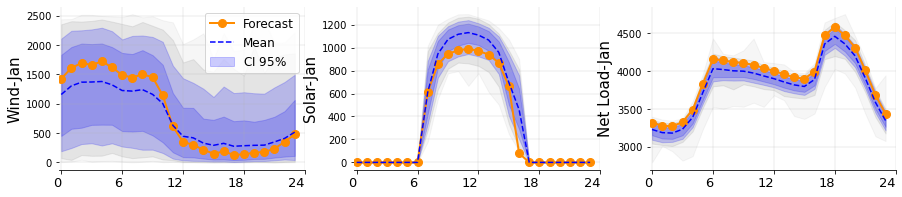

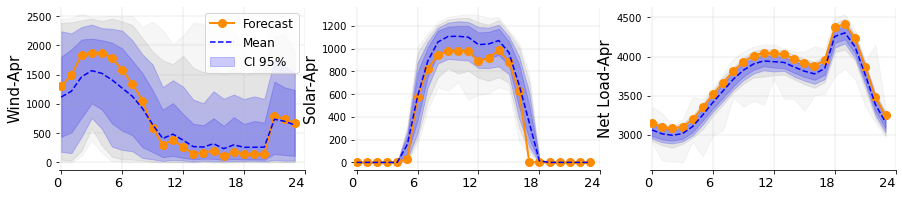

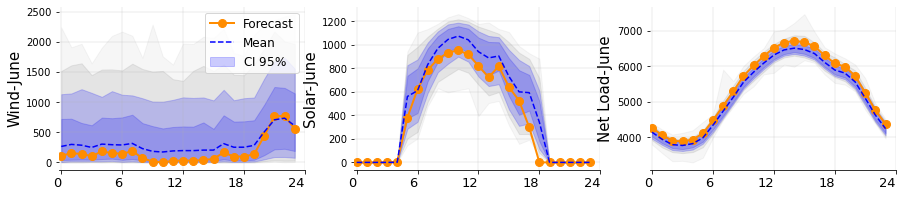

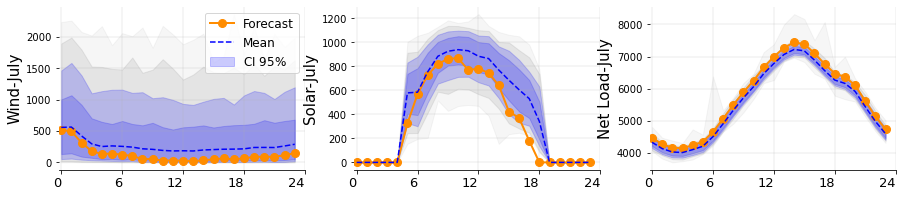

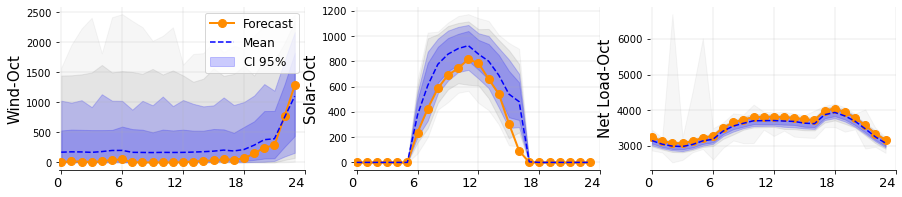

In [5]:
file_dir = "C:\\Users\\Mahashweta Patra\\Downloads\\ProcessedData\\ProcessedData"
 #"C:\\Users\\mludk\\Dropbox\\ORFEUSRTSData\\ProcessedData" #  
for date in ["Jan","Apr","June","July","Oct"]:
    Forecast = pd.read_csv(file_dir+date+"\\Forecast.csv")
    Mean = pd.read_csv(file_dir+date+"\\Mean.csv")
    WindScenarios = pd.read_csv(file_dir+date+"\\WindScenariosAggregated.csv")
    SolarScenarios=pd.read_csv(file_dir+date+"\\SolarScenariosAggregated.csv")
    LoadScenarios=pd.read_csv(file_dir+date+"\\LoadScenariosAggregated.csv")
    WindMean=Mean['WindMean']
    SolarMean=Mean['SolarMean']
    LoadMean=Mean['LoadMean']
    time= Mean['time']
    WindForecast=Forecast['WindForecast']
    SolarForecast=Forecast['SolarForecast']
    LoadForecast=Forecast['LoadForecast']
    PlotingScenarios(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date)

A few observations:
    - Wind capacity is about double compared to Solar, and hence is more likely to affect system status
    - Wind has much higher variance compared to Solar, which will further amplify the role of Wind as far as extremal scenarios go
     - Even on days where the wind forecast is close to zero, some scenarios will include outputs close to 100%
    - Net Load is lowest at night, and peaks around 6pm. Thus, scenario deviations in late afternoon are most likely to impact grid status/costs
    - While Solar has a clear diurnal pattern, Wind daily patterns vary widely across days, making that analysis more challenging

### Next we summarize the distribution of generation costs, load shed and renewable curtailment

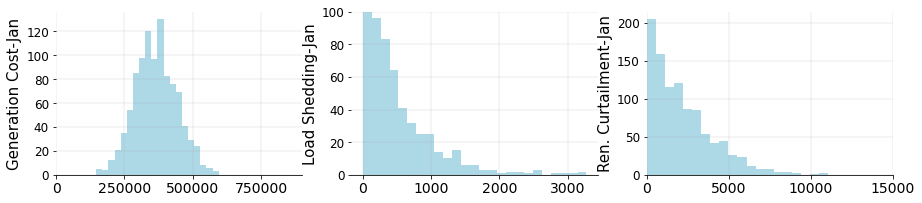

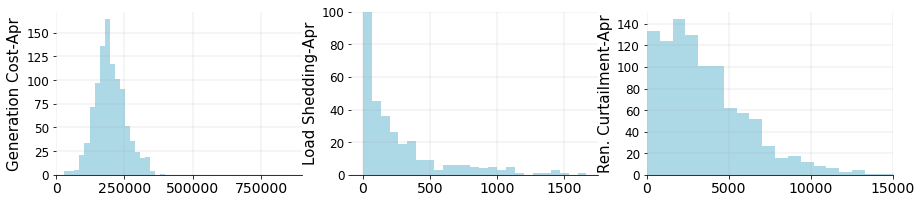

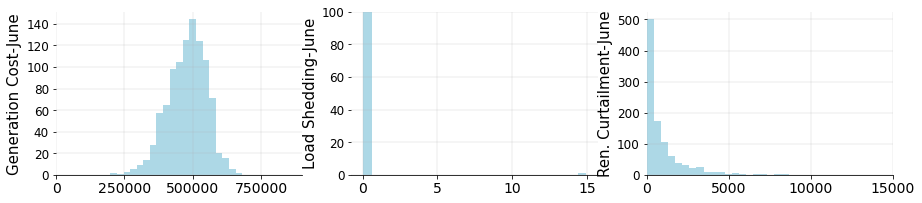

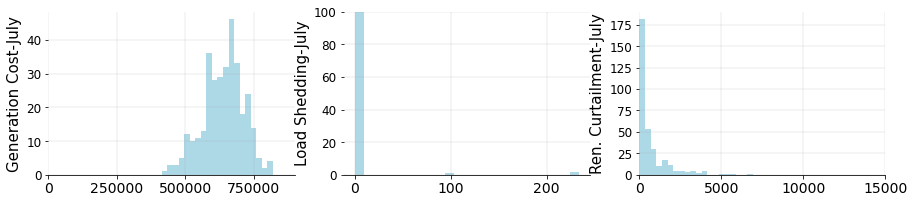

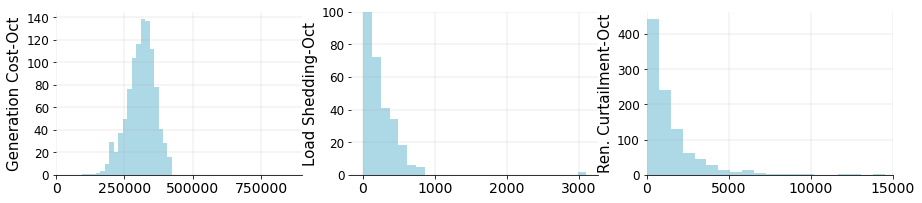

In [6]:
for date in ["Jan","Apr","June","July","Oct"]:
    VaticOutput = pd.read_csv(file_dir+date+"\\VaticOutput.csv")
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    PlotingVaticOutput(time,GenerationCostAll, LoadSheddingAll, RenewableCurtailmentAll, date)

Different days have different behavior:
    -- Jan: high cost, high shedding, high curtailment
    -- April: low cost, medium shedding, extreme curtailment
    -- June: high host, no shedding, moderate curtailment
    -- Oct: low cost, medium load shed, medium curtailment
    

There is no apparent link between scenarios that cause the highest generation costs versus the scenarios causing Load shedding or high renewable curtailment.

### Relationship between generation cost and net load

There is a strong positive relationship between net load and generation costs. So high generation costs are partly predictable
based on scenarios with low renewable production.

Daily production GWh for the mean, 63673.651625499995
Daily production GWh for the mean, 58009.53733880001
Daily production GWh for the mean, 106011.84560320002
Daily production GWh for the mean, 68962.20681959999


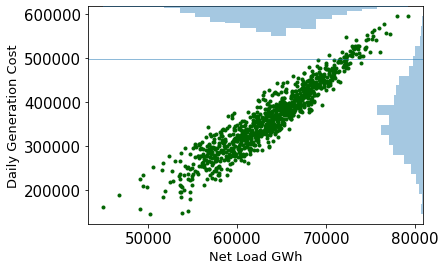

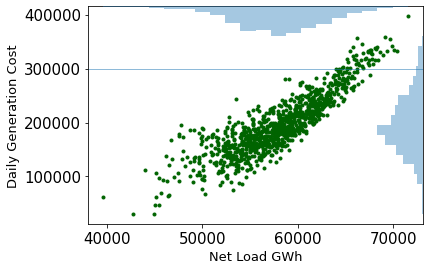

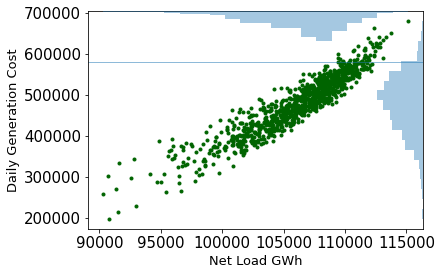

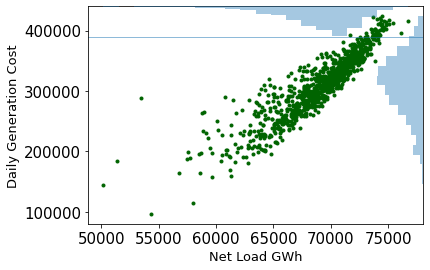

In [14]:
for date in ["Jan","Apr","June","Oct"]:
    Mean = pd.read_csv(file_dir+date+"\\Mean.csv")
    WindScenarios = pd.read_csv(file_dir+date+"\\WindScenariosAggregated.csv")
    SolarScenarios=pd.read_csv(file_dir+date+"\\SolarScenariosAggregated.csv")
    LoadScenarios=pd.read_csv(file_dir+date+"\\LoadScenariosAggregated.csv")
    VaticOutput = pd.read_csv(file_dir+date+"\\VaticOutput.csv")
    time= Mean['time']
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    PlotingRelationship1(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean, date, True)

Generation cost and daily production GWh maintain a linear relationship in case of wind and load-wind-solar but only from the solar scenarios it is not possible to predict the scenarios having high generation cost.

Scenarios having rapid/abrupt jump in net load are not directy connected to high Generation cost or daily Load shedding.


## Low wind generation is driving high generation cost

Because wind is the dominant renewable and is also more volatile, it is the main driver of generation costs. Lowest 5% of wind scenarios are highly predictive of highest 5% of generation cost scenarios.

9884.691324999998
Daily production GWh for the mean, 18611.103845999998
10307.662569999999
Daily production GWh for the mean, 17786.862796200003
2946.3540450000005
Daily production GWh for the mean, 7519.671978700001
2277.53364
Daily production GWh for the mean, 6326.272027400004


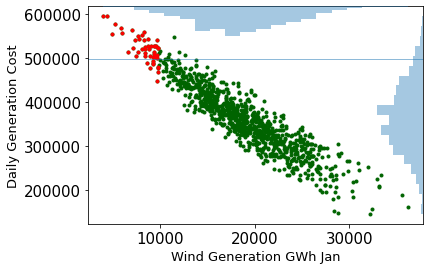

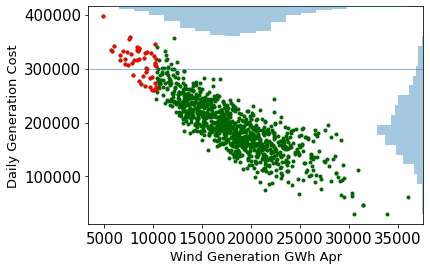

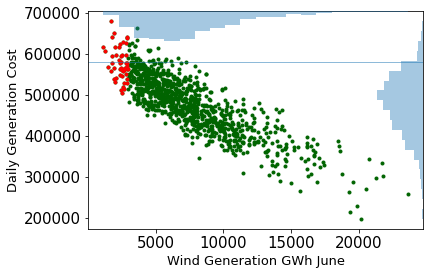

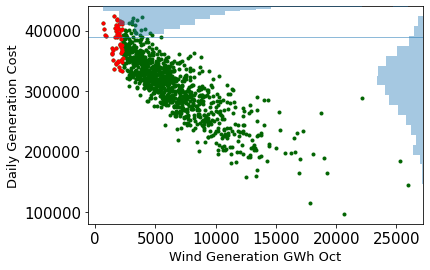

In [8]:
for date in ["Jan","Apr","June","Oct"]:
    Mean = pd.read_csv(file_dir+date+"\\Mean.csv")
    WindScenarios = pd.read_csv(file_dir+date+"\\WindScenariosAggregated.csv")
    SolarScenarios=pd.read_csv(file_dir+date+"\\SolarScenariosAggregated.csv")
    LoadScenarios=pd.read_csv(file_dir+date+"\\LoadScenariosAggregated.csv")
    VaticOutput = pd.read_csv(file_dir+date+"\\VaticOutput.csv")
    time= Mean['time']
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    PlotingRelationship2(time, WindScenarios,WindForecast,WindMean,SolarScenarios,SolarForecast,SolarMean, LoadScenarios,LoadForecast,LoadMean,date,True)

### Pattern of hourly load shed across days

This also varies widely, but generally load shed occurs either at night or evening, and appears to be driven by wind (downward spikes in wind generation?). Load shed happens during periods when high wind level is forecast.

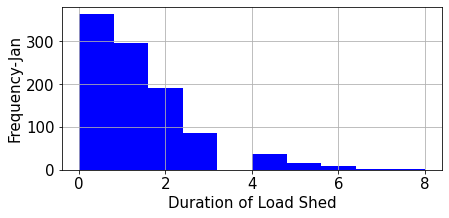

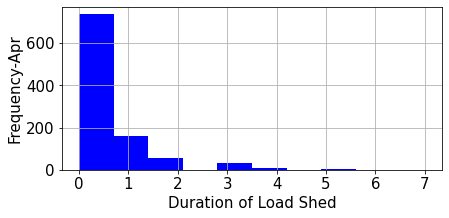

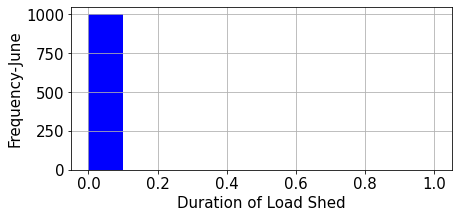

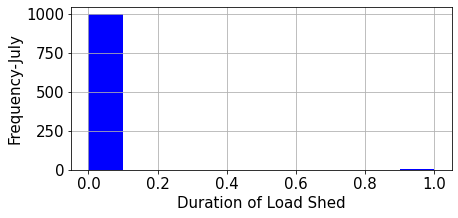

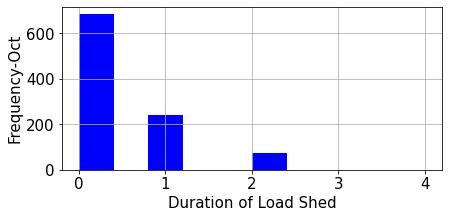

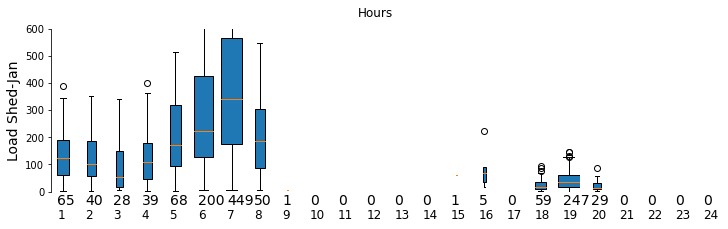

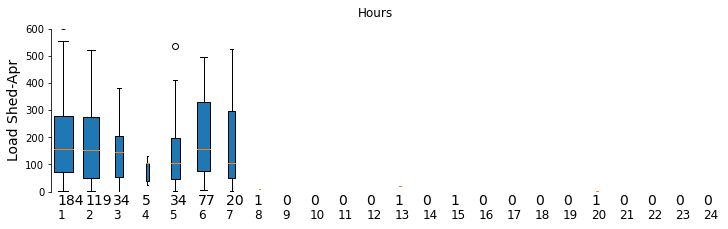

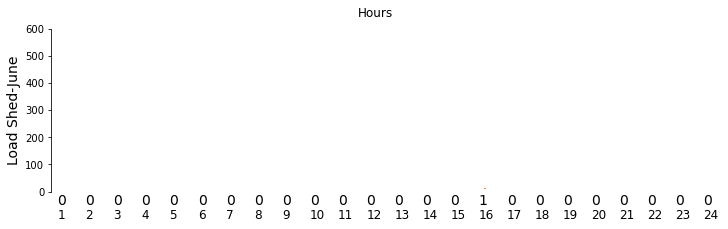

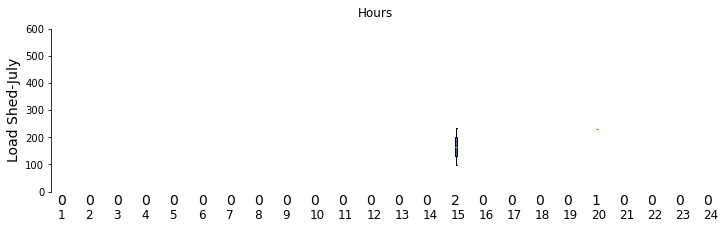

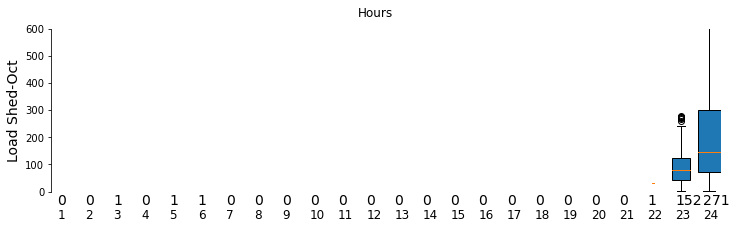

In [12]:
for date in ["Jan","Apr","June","July","Oct"]:
    LoadShedHour = pd.read_csv(file_dir+date+"\\LoadShedHour.csv")
    hours=LoadShedHour['hours']
    LoadShed=LoadShedHour['LoadShed']
    LoadShedHours(hours, LoadShed,date)
for date in ["Jan","Apr","June","July","Oct"]:
    LoadShedHour = pd.read_csv(file_dir+date+"\\LoadShedHour.csv")
    hours=LoadShedHour['hours']
    LoadShed=LoadShedHour['LoadShed']
    fig, axes = plt.subplots(nrows=1,ncols=24,figsize=(12,3))
    for i in range(0,24):
         ndx = (hours == i)
         curShed = LoadShed[ ndx]
         curShed = curShed[ curShed > 0]
         axes[i].boxplot(curShed,widths=np.sqrt(len(curShed))*0.06,patch_artist=True)
         axes[i].set_ylim(0,600)
         axes[i].axis('off')
         axes[i].text(0.75,-50,len(curShed), fontsize=14)
         axes[i].text(0.75,-100,i+1, fontsize=12)
    axes[0].set_axis_on()
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['bottom'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].set_xticks([])
    plt.suptitle('Hours')
    axes[0].set_ylabel('Load Shed-'+date,fontsize=14)

### Scenarios that produces the tail in the Vatic output
#### Sample date January: for Load-Solar-wind 
First row shows the Load-Solar-Wind scenarios and their mean. The second figure in the same row shows those scenarios which are always above the mean. The second column shows the mean and those scenarios (load-wind-solar) for which (a) highest 5% generation cost is produced, (b) highest 5% renewable curtailment, (c) Load shedding occurs.

The indices of the scenarios which are always above the mean of the scenarios [12, 230, 319, 342, 539, 587, 905]


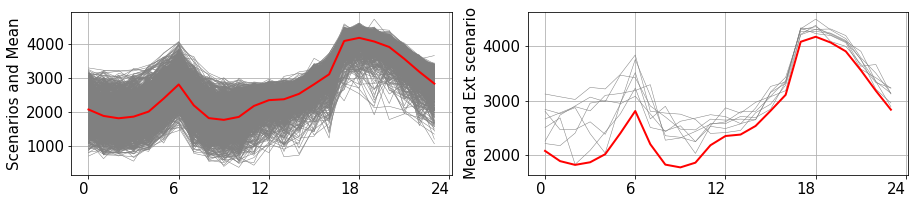

Daily production GWh for the mean, 63673.651625499995


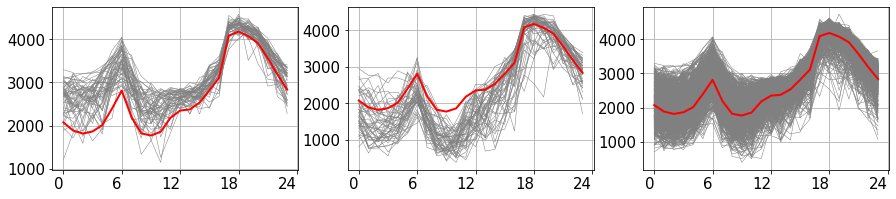

In [10]:
for date in ["Jan"]:
    Mean = pd.read_csv(file_dir+date+"\\Mean.csv")
    WindScenarios = pd.read_csv(file_dir+date+"\\WindScenariosAggregated.csv")
    SolarScenarios=pd.read_csv(file_dir+date+"\\SolarScenariosAggregated.csv")
    LoadScenarios=pd.read_csv(file_dir+date+"\\LoadScenariosAggregated.csv")
    VaticOutput = pd.read_csv(file_dir+date+"\\VaticOutput.csv")
    time= Mean['time']
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    DifferenceLoadWindSolar=LoadScenarios-WindScenarios-SolarScenarios
    Thresold=mean(DifferenceLoadWindSolar)
    GenCostIntegrationScen(DifferenceLoadWindSolar, Thresold, GenerationCostAll, RenewableCurtailmentAll, LoadSheddingAll, time,showHist=False)


#### For wind 

The indices of the scenarios which are always above the mean of the scenarios [564]


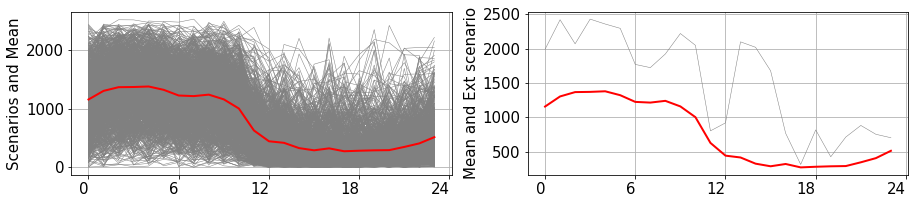

Daily production GWh for the mean, 18611.103845999998


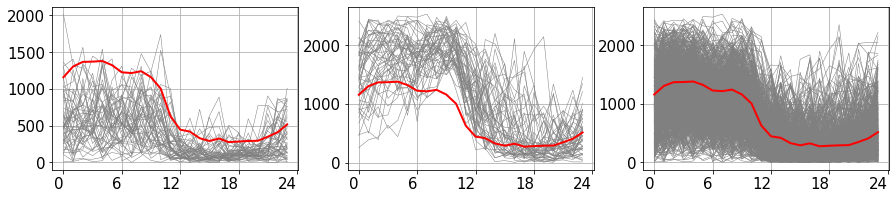

In [11]:
for date in ["Jan"]:
    Mean = pd.read_csv(file_dir+date+"\\Mean.csv")
    WindScenarios = pd.read_csv(file_dir+date+"\\WindScenariosAggregated.csv")
    SolarScenarios=pd.read_csv(file_dir+date+"\\SolarScenariosAggregated.csv")
    LoadScenarios=pd.read_csv(file_dir+date+"\\LoadScenariosAggregated.csv")
    VaticOutput = pd.read_csv(file_dir+date+"\\VaticOutput.csv")
    time= Mean['time']
    GenerationCostAll=VaticOutput['GenerationCostAll']
    LoadSheddingAll=VaticOutput['LoadSheddingAll']
    RenewableCurtailmentAll=VaticOutput['RenewableCurtailmentAll']
    DifferenceLoadWindSolar=WindScenarios
    Thresold=mean(DifferenceLoadWindSolar)
    GenCostIntegrationScen(DifferenceLoadWindSolar, Thresold, GenerationCostAll, RenewableCurtailmentAll, LoadSheddingAll, time,showHist=False)
